# stackview
Interactive image stack viewing in jupyter notebooks based on 
[ipycanvas](https://ipycanvas.readthedocs.io/) and 
[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/).

## Usage
You can use `stackview` from within jupyter notebooks as shown below.

Starting point is a 3D image dataset provided as numpy array. 

In [1]:
import stackview

import numpy as np
from skimage.io import imread
from skimage.filters import gaussian

In [2]:
image = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/Haase_MRT_tfl3d1.tif?raw=true', plugin='tifffile')

## Slice
You can then view it slice-by-slice:

In [3]:
stackview.slice(image, continuous_update=True)

# Insight
You can also get a static view using a maximum-intensity projection with additional information.

StackViewNDArray([[[   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,  992, ..., 1221, 1297,    0],
                   [   0,    0, 1526, ..., 1144, 2213,    0],
                   ...,
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0]],

                  [[   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0, 2213, ...,  916,  610,    0],
                   [   0,    0, 2365, ..., 1297, 1068,    0],
                   ...,
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0]],

                  [[   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0, 1068, ...,  153,  381,    0],
                   [   0,    0, 1526, ...,  305,  458,    0],
                   ...,
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0]],

                  ...,

                  [[   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,  610, ...,  763, 1068,  534],
                   [   0,    0,  305, ..., 1221,  381,  610],
                   ...,
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0]],

                  [[   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,  229, ...,  763,  916,    0],
                   [   0,    0,  458, ...,  839,  992,    0],
                   ...,
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0]],

                  [[   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0, 1144, ...,  687, 1450,    0],
                   [   0,    0,  381, ..., 1068,  763,    0],
                   ...,
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0],
                   [   0,    0,    0, ...,    0,    0,    0]]],
                 dtype=uint16)
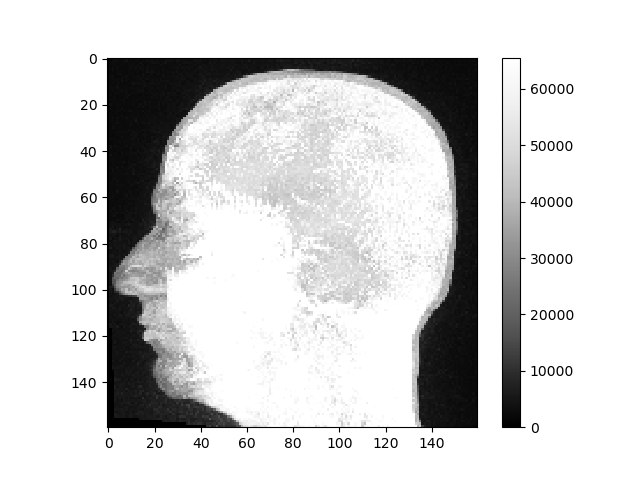
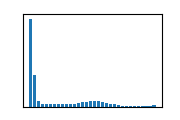

In [4]:
stackview.insight(image)

# Annotate
To draw label images, use `annotate`.

In [5]:
import numpy as np
labels = np.zeros(image.shape).astype(np.uint32)

stackview.annotate(image, labels)

## Picker
To read the intensity of pixels where the mouse is moving, use the picker.

In [6]:
stackview.picker(image, continuous_update=True)

## Orthogonal
Orthogonal views are also available:

In [7]:
stackview.orthogonal(image, continuous_update=True)

## Curtain
For visualization of an original image in combination with a processed version, a curtain view may be helpful:

In [8]:
modified_image = image.max() - image

In [9]:
stackview.curtain(image, modified_image, continuous_update=True)

One can also use the curtain to visualize semantic segmentation results as label images.

In [10]:
labels = (image > 5000)*1 + (image > 15000)*1 + (image > 30000)*1

In [11]:
stackview.curtain(image, labels, continuous_update=True)

The curtain can also be partially transparent using the alpha value.

In [12]:
stackview.curtain(image, labels, continuous_update=True, alpha=0.3)

The curtain also works with 2D data

In [13]:
slice_image = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/blobs.tif?raw=true', plugin='tifffile')

In [14]:
from skimage.filters import threshold_otsu
binary = (slice_image > threshold_otsu(slice_image))

In [15]:
binary.shape, slice_image.shape

((254, 256), (254, 256))

In [16]:
stackview.curtain(slice_image, binary, continuous_update=True)

Also label images are supported. Images are shown as labels in case their pixel type is (unsigned) integer 32-bit or 32-bit.

In [17]:
from skimage.measure import label
labels = label(binary)

In [18]:
stackview.curtain(slice_image, labels, continuous_update=True)

## Side-by-side
A side-by-side view of two stacks is also available. It might be useful for colocalization visualization or showing subsequent time points of a timelapse.

In [19]:
image_stack = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/CalibZAPWfixed_000154_max.tif?raw=true', plugin='tifffile').swapaxes(1,2)

In [20]:
stackview.side_by_side(image_stack[1:], image_stack[:-1], continuous_update=True, display_width=300)

In [21]:
labels_stack = np.asarray([label(image > 100) for image in image_stack])

In [22]:
stackview.side_by_side(image_stack, labels_stack, continuous_update=True, display_width=300)

## Interact
You can also use `interact` to explore parameters of some supported functions that process images, e.g. from [scikit-image](https://scikit-image.org/):

In [23]:
from skimage.filters.rank import maximum
stackview.interact(maximum, slice_image)

In [24]:
from skimage.filters import gaussian
stackview.interact(gaussian, slice_image)

This might be interesting for custom functions executing image processing workflows.

In [25]:
from skimage.filters import gaussian, threshold_otsu, sobel
def my_custom_code(image, sigma:float = 1, show_labels: bool = True):
    sigma = abs(sigma)
    blurred_image = gaussian(image, sigma=sigma)
    binary_image = blurred_image > threshold_otsu(blurred_image)
    edge_image = sobel(binary_image)
    
    if show_labels:
        return label(binary_image)
    else:
        return edge_image * 255 + image 

stackview.interact(my_custom_code, slice_image, continuous_update=True)

If you want to configure the range of a slider explicitly, you need to hand over the [ipywidgets slider](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#FloatSlider) as default value:

In [26]:
from skimage.filters import gaussian
from ipywidgets import FloatSlider
stackview.interact(gaussian, slice_image, sigma=FloatSlider(min=0, max=100, value=15), continuous_update=True)

## Assist
The `stackview.assist()` function can guide you through all imported (and supported) image processing functions.

In [27]:
stackview.assist(context=globals(), continuous_update=True)

## Some more tests with silly images

In [28]:
import numpy as np
silly_image = np.zeros((100, 100))
silly_image[:,50:] = 1
silly_image[50:] = silly_image[50:] + 2

stackview.picker(silly_image.astype(np.uint32))

In [29]:
silly_image = np.zeros((3, 3))
silly_image[:,1:] = 1
silly_image[1:] = silly_image[1:] + 2

stackview.picker(silly_image.astype(np.uint32), zoom_factor=20)